# Análise Crédito - Resultados 

## Introdução
Este notebook apresenta os resultados do modelo, contendo as métricas da validação cruzada após a otimização do modelo pelo Optuna (usando dataset de treino). Além disso, contém métricas do modelo utilizando o dataset de validação (Dataset *out-of-sample*). Também apresenta uma matriz de confusão para os dois modelos *lightgbm* e *xgboost* e um exemplo de modelo explicativo SHAP para o melhor modelo em relação a métrica  PR-AUC.


## Contexto do problema
Criar um modelo de machine learning que irá responder, com uma certa probabilidade, quais as chances de uma pessoa com a coluna **pre_approved** igual a 1 tem de ser enviado para um analista (**sent_to_analysis**).  

## Dados
- 35 mil linhas
- 1 coluna para filtro **pre_approved**
- 1 coluna com rótulo **sent_to_analysis**
- 1 coluna como identificador
- Possíveis 29 colunas como características
- 24 colunas categóricas (incluindo as boleanas)
- 7 colunas numéricas 

## Resultados 

O modelo que desempenhou melhor foi o lightgbm com PR-AUC de 0.42 contra 0.37 (*xgboost*) no dataset de validação. Nenhuma das calibrações mostraram resultados satisfatorios quanto a saída do modelo. 

## Resultados

O modelo lightgbm se mostrou melhor, em praticamente todos os folds, na métrica  PR-AUC, sendo esta a nossa métrica principal. Para o dado de validação o modelo também mostrou uma melhor performance com 0.42 vs 0.37 do xgboost. 

A matriz de confusão mostra que o modelo lightgbm manda mais pessoas para análise quando comparado ao xgboost, dando mais oportunidade de negócio.

Para o modelo SHAP, quanto maior o **collateral_debt** ou a dívida que o veículo possui, menor as chances de conseguir um empréstimo. Aqueles que completam o formulário possuem mais chances de ir para análise de crédito. A coluna **auto_model** do carro parece criar um viés no modelo apesar de ganhar algumas posições dentro do dataset de teste e de validação. Talvez seja uma feature para ser removida em próximos passos.  Carros mais novos e clientes sem restrições, sejam elas verificadas ou informadas, tem chances acrescentadas para conseguir ir para os analistas. Um fator de grande influência é a renda que quanto maior, mais chances de serem selecionados para análise. Esta mesma lógica vale para o valor das parcelas que serão pagas. 

# Imports

In [1]:
import seaborn as sns
import warnings
import pandas as pd
import matplotlib.pyplot as plt; 
import lightgbm as lgb
import shap
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# Parameters

# Definitions

In [3]:
FEATURES = ["monthly_income", 'collateral_value', "loan_amount", "collateral_debt","verified_restriction", "dishonored_checks", 
            "expired_debts", "banking_debts", "commercial_debts", "protests", "informed_restriction", "monthly_payment", "auto_brand",
            "auto_model", "auto_year", "form_completed", "channel", "landing_page", "landing_page_product", "utm_term"]
METRICS_CROSS_VAL_TRAIN = "../datasets/metrics.csv"
METRICS_VALIDATION_SET = "../datasets/metrics_val.csv"

# Metrics

In [4]:
metrics_cross_val_train_df = pd.read_csv(METRICS_CROSS_VAL_TRAIN)
metrics_val_set_df = pd.read_csv(METRICS_VALIDATION_SET)

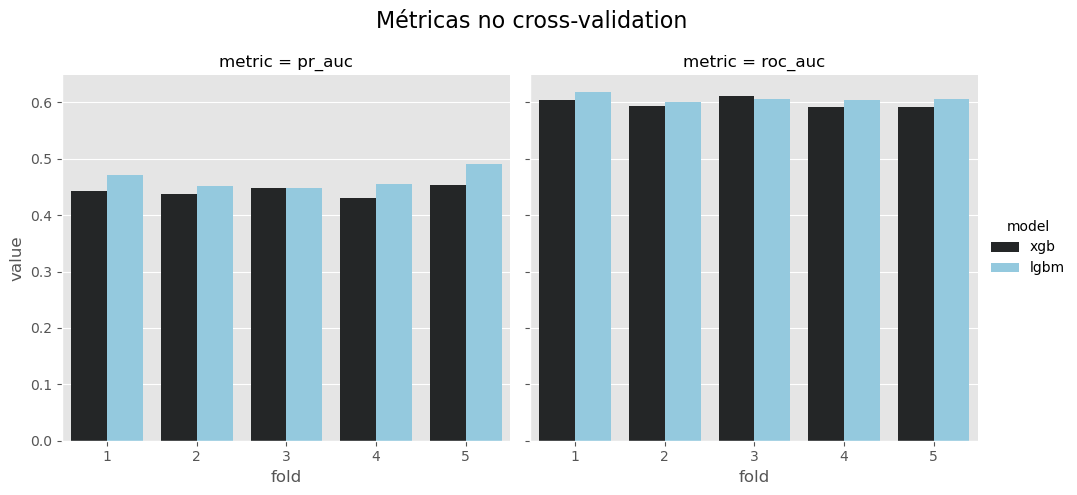

In [5]:
g = sns.catplot(
    data=metrics_cross_val_train_df, x="fold", y="value", col="metric", hue="model",
    kind="bar", height=5, aspect=1.0, color='skyblue',
)
g.fig.suptitle('Métricas no cross-validation', fontsize=16)

# Adjust the title position to prevent overlap
g.fig.subplots_adjust(top=0.85)

plt.show()

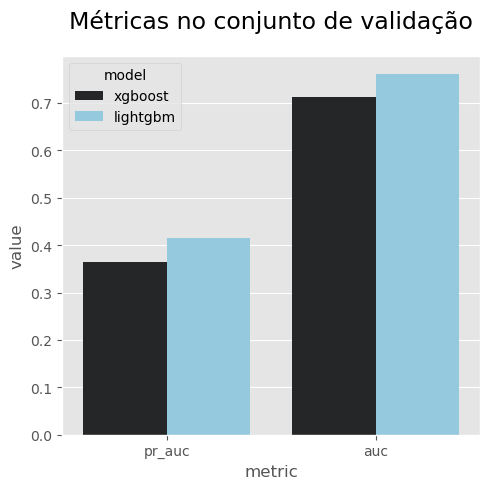

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(
    data=metrics_val_set_df, x="metric", y="value",  hue="model", color='skyblue',
)
axes.set_title('Métricas no conjunto de validação', fontsize=17, pad=20)
plt.tight_layout()
plt.show()

# Confusion Matrix

In [7]:
cm_xgb = np.load("../datasets/confusion_matrix_xgboost.npy")
cm_lgb = np.load("../datasets/confusion_matrix_lightgbm.npy")

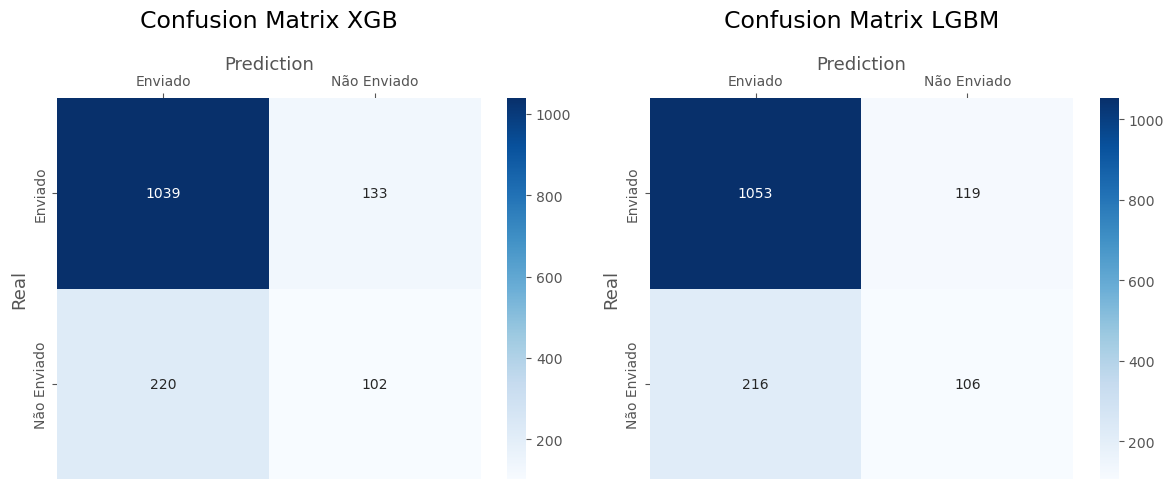

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First confusion matrix (XGB)
sns.heatmap(cm_xgb, 
            annot=True, 
            fmt='g', 
            xticklabels=['Enviado', 'Não Enviado'],
            yticklabels=['Enviado', 'Não Enviado'],
            cmap="Blues",
            ax=axes[0])  # Plot on the first axis
axes[0].set_title('Confusion Matrix XGB', fontsize=17, pad=20)
axes[0].set_ylabel('Real', fontsize=13)
axes[0].set_xlabel('Prediction', fontsize=13)
axes[0].xaxis.set_label_position('top')  # Move label on top
axes[0].xaxis.tick_top()

# Second confusion matrix (LGBM)
sns.heatmap(cm_lgb, 
            annot=True, 
            fmt='g', 
            xticklabels=['Enviado', 'Não Enviado'],
            yticklabels=['Enviado', 'Não Enviado'],
            cmap="Blues",
            ax=axes[1])  # Plot on the second axis
axes[1].set_title('Confusion Matrix LGBM', fontsize=17, pad=20)
axes[1].set_ylabel('Real', fontsize=13)
axes[1].set_xlabel('Prediction', fontsize=13)
axes[1].xaxis.set_label_position('top')  # Move label on top
axes[1].xaxis.tick_top()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Explanation (SHAP) 

In [9]:
bst = lgb.Booster(model_file=f"../models/lgbm_model_fold_5.txt") 

In [15]:
df_train = pd.read_pickle("../datasets/df_train_fold_5.pkl")
df_test = pd.read_pickle("../datasets/df_test_fold_5.pkl")
df_val = pd.read_pickle("../datasets/val_data.pkl")

In [16]:
explainer_lightgbm = shap.TreeExplainer(bst)
shap_values_lightgbm = explainer_lightgbm(df_train[FEATURES])

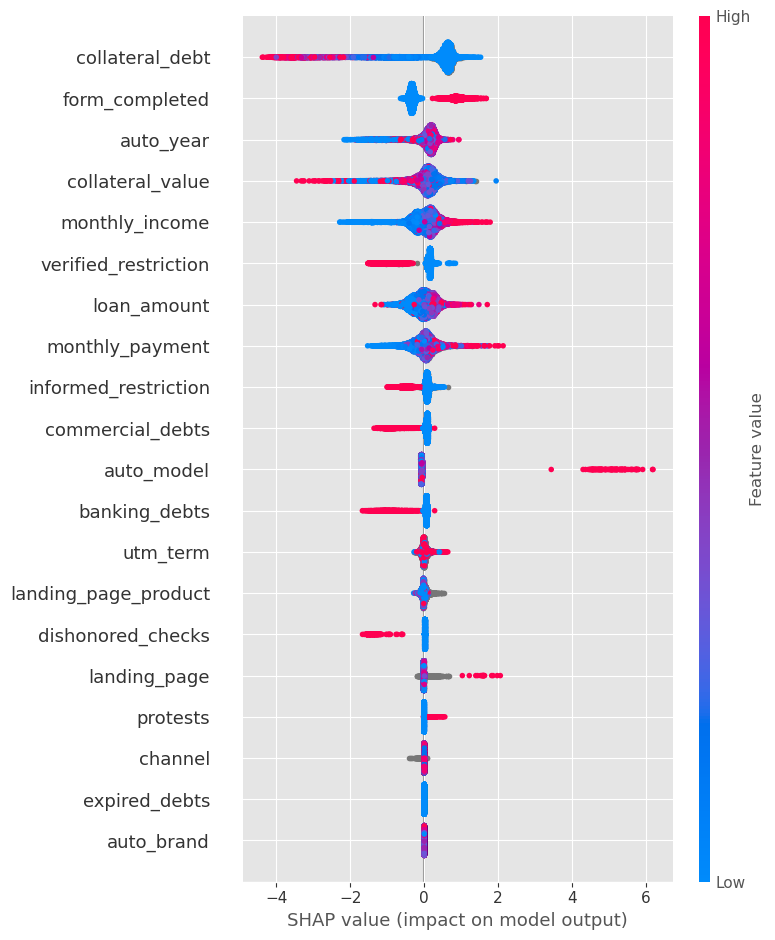

In [18]:
shap.summary_plot(shap_values_lightgbm, df_train[FEATURES])

In [19]:
explainer_lightgbm = shap.TreeExplainer(bst)
shap_values_lightgbm = explainer_lightgbm(df_test[FEATURES])

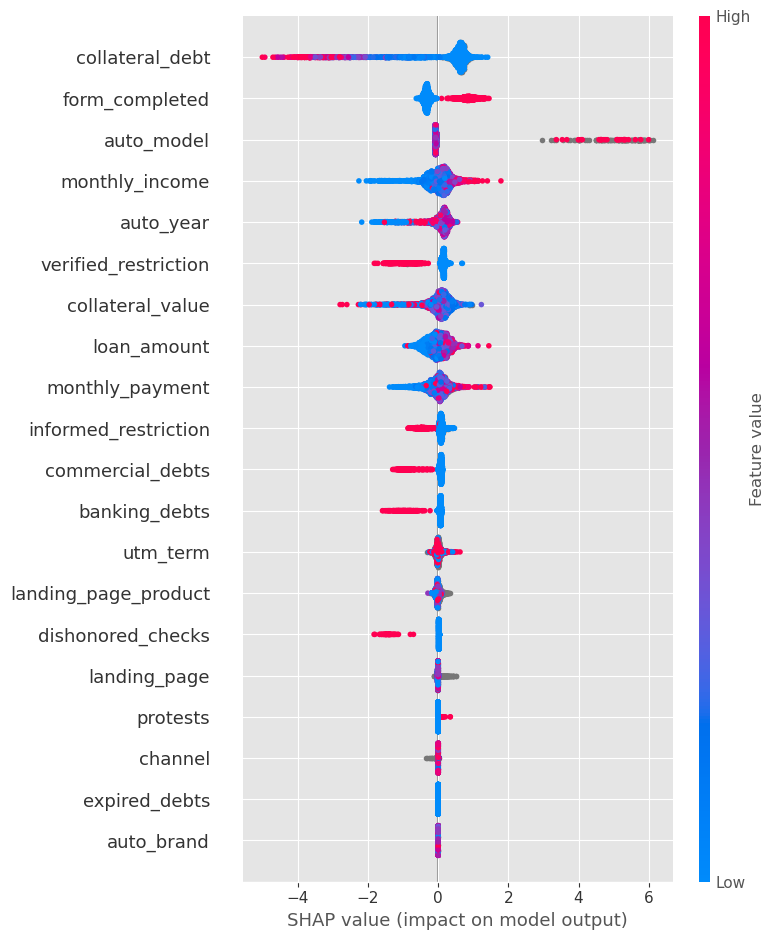

In [20]:
shap.summary_plot(shap_values_lightgbm, df_test[FEATURES])

In [21]:
explainer_lightgbm = shap.TreeExplainer(bst)
shap_values_lightgbm = explainer_lightgbm(df_val[FEATURES])

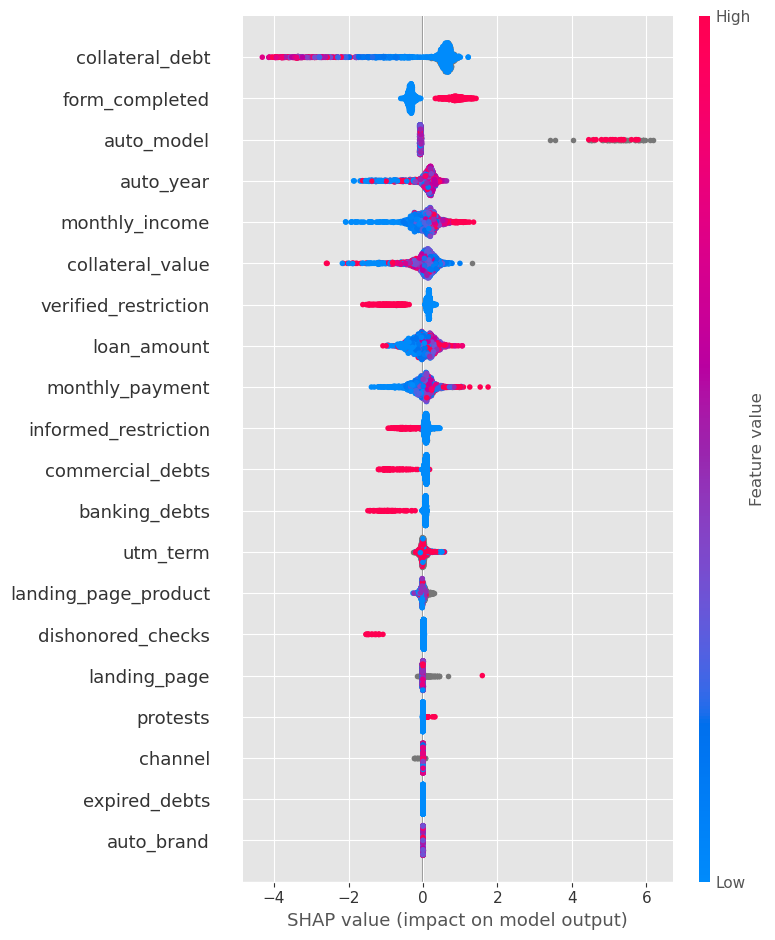

In [22]:
shap.summary_plot(shap_values_lightgbm, df_val[FEATURES])

-----------------------------------------------------------------------------------------------------------------

# Planos Futuros

- Fazer um *feature selection* utilizando o SHAP como orientador para remover aquelas features que não possuem tanta importância para o modelo
- Fazer um *feature selection* utilizando correlação entre features, por exemplo: **monthly_payment** e **loan_amount**.
- Fazer teste com outros parâmetros do modelo dentro do *Optuna*
- Fazer segmentação de cliente através de treshold e criar filas de acordo com esta segmentação (Criar uma política por cima da saída do modelo)
      - Pode testar diferentes valores de treshold nesta etapa, depende do risco que se quer para o neǵocio
- Fazer um estudo mais aprofundado quanto as características com vieses (idade, cidade, estado etc) e verificar seus ganhos/perdas para o modelo e quanto ao *fairness*
- Incluir dados externos ou de terceiros (serasa, boavista) 